In [30]:
#import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

# Import models
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest,f_classif, chi2
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot
from collections import Counter
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso


# metrics evaluation
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import cohen_kappa_score
import statsmodels.api as sm
from sklearn.inspection import permutation_importance
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

# To standardise data
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler

# For train/test split
from sklearn.model_selection import train_test_split


from sklearn.feature_selection import VarianceThreshold as vt
from imblearn.pipeline import make_pipeline, Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV

In [31]:
#import CSVs, assign headers and remove quotations from column headers
white_wine = pd.read_csv(r'C:\Users\Killian\Projects\Wine analysis\Wine data\winequality-white.csv', sep=';',header=0, engine='python')

In [32]:
#white_wine['label'] = white_wine['quality'].apply(lambda value: 'low'
#if value <= 4 else 'medium-low'
#if value == 5 else 'medium' if value == 6 else 'medium-high' if value == 7 else 'high')

In [33]:
wine = []
for column in white_wine.columns[0:-2]:
        wine.append([white_wine[column].astype(float).skew().round(2), white_wine[column].astype(float).kurt().round(2)])

wine_stats = pd.DataFrame(wine, index=[white_wine.columns[0:-2]], columns=['Skewness', 'Kurtosis'])
display(wine_stats)

,Skewness,Kurtosis
fixed acidity,0.65,2.17
volatile acidity,1.58,5.09
citric acid,1.28,6.17
residual sugar,1.08,3.47
chlorides,5.02,37.56
free sulfur dioxide,1.41,11.47
total sulfur dioxide,0.39,0.57
density,0.98,9.79
pH,0.46,0.53
sulphates,0.98,1.59


In [34]:

#white_wine["label"].value_counts()

In [35]:
white_wine['label'] = white_wine['quality'].apply(lambda value: 'low' if value <= 5 else 'medium' if value <=6 else 'high')
white_wine.head()
white_wine["label"].value_counts()

medium    2198
low       1640
high      1060
Name: label, dtype: int64

In [36]:
features=white_wine.columns
features

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'label'],
      dtype='object')

In [37]:
white_wine['category'] = white_wine.label.map({"low" : "0", "medium" : "1", "high" : "2"}).astype('int')
white_wine= white_wine.drop(columns="quality")
print(white_wine.category.value_counts())
white_wine.category.dtypes


1    2198
0    1640
2    1060
Name: category, dtype: int64


dtype('int32')

In [38]:
white_wine.tail()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,label,category
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,medium,1
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,low,0
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,medium,1
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,high,2
4897,6.0,0.21,0.38,0.8,0.020,22.0,98.0,0.98941,3.26,0.32,11.8,medium,1


In [39]:
#Create target and features for algorithm
#Full feature list for ease of access while doing Backward Elimination and refining model: 'fixed acidity', 'volatile acidity', 'residual sugar', 'density', 'pH', 
# 'sulphates','citric acid', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'alcohol'
X = white_wine.copy()
y = X.category #target
X =white_wine.drop(columns=['category', 'label', 'total sulfur dioxide', 'density']) #, 'citric acid', 'total sulfur dioxide', 'density', 'pH', 'volatile acidity'
# features we want to test, except target and correlated values, i.e. Quality and Label. 
# Final list will include features removed due to results from Backward Elimination.
X_list = list(X.columns)
print(X.columns.tolist())
print(y)

['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'pH', 'sulphates', 'alcohol']
0       1
1       1
2       1
3       1
4       1
       ..
4893    1
4894    0
4895    1
4896    2
4897    1
Name: category, Length: 4898, dtype: int32


In [40]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #, stratify=y) # random state controls the shuffling applied before the split. 42 is a popular random seed.
#stratification ensures equitable split of low/medium/high quality across training and test data
print(Counter(y_train), Counter(y_test))
print('Features:', list(X))

Counter({1: 1766, 0: 1319, 2: 833}) Counter({1: 432, 0: 321, 2: 227})
Features: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'pH', 'sulphates', 'alcohol']


In [41]:
# data normalization with sklearn
#from sklearn.preprocessing import MinMaxScaler

# fit scaler on training data
#norm = MinMaxScaler().fit(X_train)
#norm2 = MinMaxScaler().fit(X_test)

# transform training data
#X_train_norm = norm.transform(X_train)

# transform testing data
#X_test_norm = norm2.transform(X_test)

In [42]:
# data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler(with_centering=True, with_scaling=True, quantile_range=(25.0, 75.0), copy=True)
#scaler =  MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)

model = KNeighborsClassifier()
model.fit(X_train_norm, y_train)

X_test_norm = scaler.transform(X_test)
y_pred = model.predict(X_test_norm)

In [43]:
# define pipeline
model = KNeighborsClassifier()
under = RandomUnderSampler(sampling_strategy={1: 1500, 0: 1300, 2: 833})
over = SMOTE(sampling_strategy={1: 1500, 0: 1300, 2: 1100})
#steps = [('o', over), ('u', under), ('m', model)]
#pipeline = Pipeline(steps=steps)
X_train_norm, y_train = under.fit_resample(X_train_norm, y_train)
X_train_norm, y_train = over.fit_resample(X_train_norm, y_train)

In [44]:
from sklearn.model_selection import RepeatedStratifiedKFold
from numpy import mean

# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=7, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='roc_auc_ovr', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC One vs Rest: %.3f' % mean(scores))

#Compared to ove v one, sensitive to class imbalance even when average == 'macro', because class imbalance affects the composition of each of the ‘rest’ groupings.

Mean ROC AUC One vs Rest: 0.715


In [45]:
#Below I am testing to make sure the shapes are as predicted (column numbers match)

print('Training Features Shape:', X_train_norm.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test_norm.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (3900, 9)
Training Labels Shape: (3900,)
Testing Features Shape: (980, 9)
Testing Labels Shape: (980,)


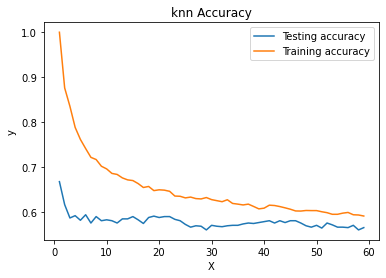

In [46]:
neighbors=np.arange(1,60)
train_accuracy=np.empty(len(neighbors))
test_accuracy=np.empty(len(neighbors))

for i, k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_norm, y_train)
    train_accuracy[i]=knn.score(X_train_norm, y_train)
    test_accuracy[i]=knn.score(X_test_norm, y_test)

plt.title("knn Accuracy")
plt.plot(neighbors, test_accuracy, label="Testing accuracy")
plt.plot(neighbors, train_accuracy, label="Training accuracy")
plt.legend()
plt.xlabel("X")
plt.ylabel("y")
plt.show()

Minimum error: 0.33163265306122447 at K = 0


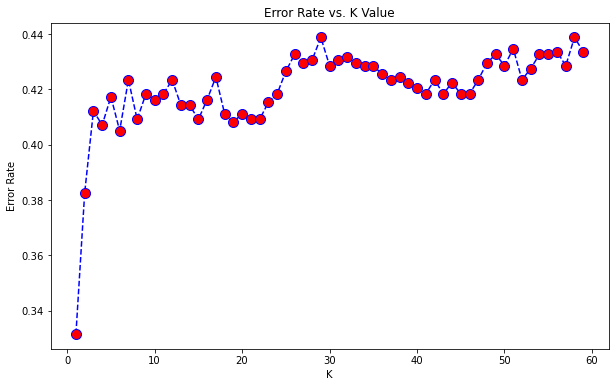

In [47]:
error_rate = []
for i in range(1,60):
 knn = KNeighborsClassifier(n_neighbors=i)
 knn.fit(X_train_norm,y_train)
 pred_i = knn.predict(X_test_norm)
 error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,60),error_rate,color='blue', linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Minimum error:",min(error_rate),"at K =",error_rate.index(min(error_rate)))

In [48]:
model = KNeighborsClassifier(n_neighbors=1, metric="manhattan")
model.fit(X_train_norm, y_train)
model.get_params() #See the parameters used 

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'manhattan',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 1,
 'p': 2,
 'weights': 'uniform'}

In [49]:
# make predictions for test data
#print(model.score(X_test, y_test))

y_pred = model.predict(X_test_norm)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 68.47%


In [50]:
#Poor agreement = Less than 0.20 (including negative numbers)
#Fair agreement = 0.20 to 0.40
#Moderate agreement = 0.40 to 0.60
#Good agreement = 0.60 to 0.80
#Very good agreement = 0.80 to 1.00

# Cohen’s Kappa is a statistical measure that is used to measure the reliability of 
# two raters who are rating the same quantity and identifies how frequently the raters are in agreement. 
#It assumes balanced classes and so should not be used where a large class imbalance lies.


kappa = cohen_kappa_score(y_pred, y_test)
print("Cohen-Kappa score:", round(kappa, 2))

Cohen-Kappa score: 0.52


In [51]:
report = print(classification_report(y_test, y_pred, target_names=["low","medium", "high"]))

              precision    recall  f1-score   support

         low       0.69      0.71      0.70       321
      medium       0.69      0.64      0.67       432
        high       0.66      0.74      0.70       227

    accuracy                           0.68       980
   macro avg       0.68      0.70      0.69       980
weighted avg       0.69      0.68      0.68       980



In [52]:
print("Confusion matrix:")
labels = np.unique(y_test)
a = confusion_matrix(y_test, y_pred, labels=labels)
a = pd.DataFrame(a, index=("low", "medium", "high"), columns=("low", "medium", "high"))
display(a)

Confusion matrix:


,low,medium,high
low,227,76,18
medium,89,276,67
high,13,46,168


<AxesSubplot:>

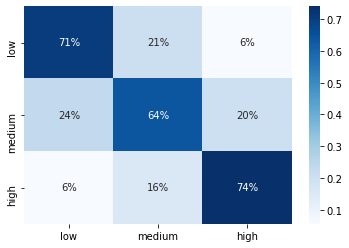

In [53]:
import seaborn as sns
sns.heatmap(a.T/np.sum(a.T), annot=True, 
            fmt='.0%', cmap='Blues')

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [55]:
cf_matrix_3x3=confusion_matrix(y_test, y_pred)

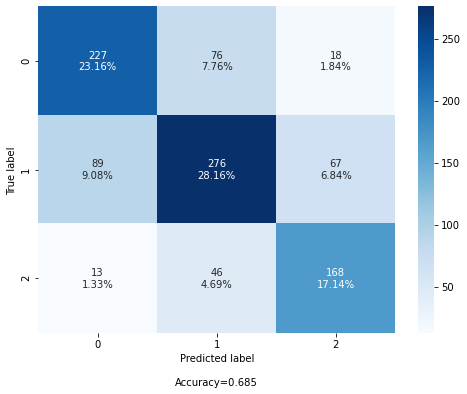

In [56]:
make_confusion_matrix(cf_matrix_3x3, figsize=(8,6), cbar=True)

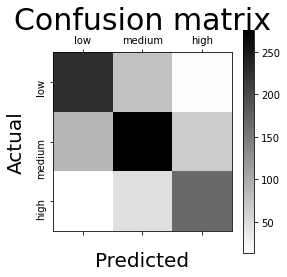

In [57]:
def plot_confusion_matrix(a, title='Confusion matrix', cmap=plt.cm.gray_r):
    plt.matshow(a, cmap=cmap) # imshow
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(a.columns))
    plt.xticks(tick_marks, a.columns)
    plt.yticks(tick_marks, a.index, rotation=90)
    #plt.tight_layout()
    plt.ylabel('Actual', labelpad=10, fontsize=20)
    plt.xlabel('Predicted', labelpad=20, fontsize=20)

plot_confusion_matrix(a)

In [58]:
#kfold = KFold(n_splits=10, random_state=7, shuffle=True)
print(cross_val_score(model, X, y, cv=3))

[0.46111451 0.44580527 0.45343137]


In [59]:
#Its validation performance, measured via the score, is significantly larger than the chance level. (0.33)
# This makes it possible to use the permutation_importance function to probe which features are most predictive. 
# The scores represent the predictive quality of the feature.

#Features that are important on the training set but not on the held-out set might cause the model to overfit.

r = permutation_importance(model, X_test_norm, y_test, n_repeats=30, random_state=0)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{features[i]:<8} "
        f"{r.importances_mean[i]*100:.3f}", "%",
        f" +/- {r.importances_std[i]*100:.3f}", "%")

pH       4.935 %  +/- 0.803 %
citric acid 4.500 %  +/- 1.143 %
volatile acidity 3.997 %  +/- 0.659 %
density  3.980 %  +/- 1.120 %
free sulfur dioxide 3.810 %  +/- 0.783 %
chlorides 3.463 %  +/- 0.970 %
total sulfur dioxide 3.415 %  +/- 0.930 %
fixed acidity 2.867 %  +/- 0.824 %
residual sugar 1.759 %  +/- 0.852 %


Best alpha using built-in LassoCV: 0.001156
Best score using built-in LassoCV: 0.284820
Lasso picked 8 variables and eliminated the other 1 variables


<AxesSubplot:>

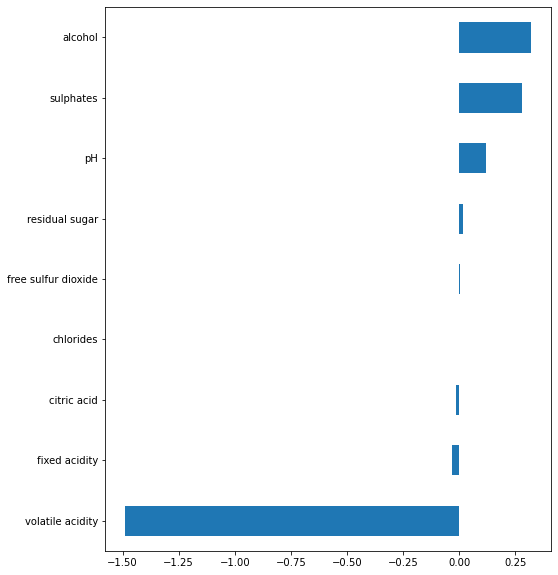

In [60]:
reg = LassoCV()
reg.fit(X, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

imp_coef = coef.sort_values()
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")

In [61]:
#If you are set on using KNN though, then the best way to estimate feature importance is by 
# taking the sample to predict on, and computing its distance from each of its nearest neighbors 
# for each feature (call these neighb_dist). Then do the same computations for a few random points 
# (call these rand_dist) instead of the nearest neighbors. Then for each feature, you take the ratio 
# of neighb_dist / rand_dist, and the smaller the ratio, the more important that feature is.
